In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
config = f"""
execution:
    exp_id: exp_035
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs
    oof_exp: exp_034

feature:
    agg_freq: 12 # [step]

xgboost:    
    objective: "reg:squarederror"
    learning_rate: 0.01  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 7  # 3-8。7くらいでいい。
    colsample_bytree: 0.5  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [3]:
sub = pd.read_csv(f'/kaggle/output/{CFG["dataset"]["oof_exp"]}/submission.csv')
oof = pd.read_csv(f'/kaggle/output/{CFG["dataset"]["oof_exp"]}/oof.csv')
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
display(sub.head())
display(oof.head())
display(labels.head())

,series_id,raw_step,event,score,step
0,038441c925bb,10865.5,wakeup,0.712949,10859
1,038441c925bb,27437.5,wakeup,0.873548,27431
2,038441c925bb,44117.5,wakeup,0.639660,44111
3,038441c925bb,61133.5,wakeup,0.588710,61127
4,038441c925bb,94313.5,wakeup,0.469724,94307


,target,step,series_id,fold,oof_stage1,raw_oof,oof_stage2,STAGE,minutes,oof
0,1,5.5,038441c925bb,2,NaN,0.999338,NaN,NaN,NaN,NaN
1,1,17.5,038441c925bb,2,NaN,0.999394,NaN,NaN,NaN,NaN
2,1,29.5,038441c925bb,2,NaN,0.999235,NaN,NaN,NaN,NaN
3,1,41.5,038441c925bb,2,NaN,0.999139,NaN,NaN,NaN,NaN
4,1,53.5,038441c925bb,2,NaN,0.993710,NaN,NaN,NaN,NaN


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


## 正解ラベルを作成

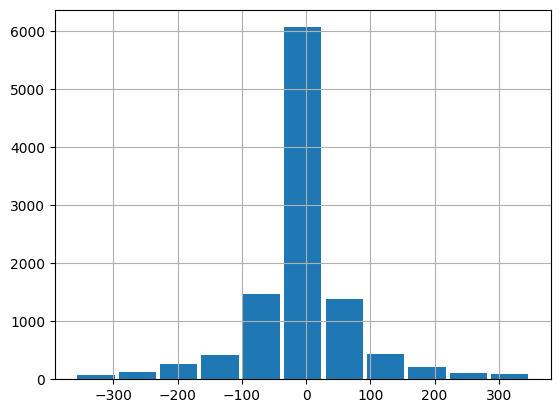

series_id    10662195
step         10662195
fold         10662195
raw_oof      10662195
minutes       1483857
target          10630
sub_step        10630
raw_step        10630
event           10630
score           10630
dtype: int64

In [4]:
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    targets = np.empty(len(sub_df))
    for i, sub_step in enumerate(sub_df["step"].values):
        best_step = np.inf
        for step in label_df["step"].values:
            if abs(step - sub_step) < abs(best_step - sub_step):
                best_step = step
        target = best_step - sub_step
        if abs(target) > 360:
            target = 0
        targets[i] = target
    sub_df["target"] = targets
    sub_df["sub_step"] = sub_df["step"].values
    dfs.append(sub_df)
sub = pd.concat(dfs).reset_index(drop=True)
plt.hist(sub["target"].values, bins=11, rwidth=0.9)
plt.grid()
plt.show()

oof = oof[["series_id", "step", "fold", "raw_oof", "minutes"]].merge(
    sub[["target", "series_id", "sub_step", "raw_step", "event", "score"]], 
    left_on=["series_id", "step"], 
    right_on=["series_id", "raw_step"], 
    how="left",
    )
(~oof.isna()).sum()

In [5]:
(oof.target ** 2).mean() ** 0.5

83.61409023931019

In [6]:
oof.head()

,series_id,step,fold,raw_oof,minutes,target,sub_step,raw_step,event,score
0,038441c925bb,5.5,2,0.999338,NaN,NaN,NaN,NaN,NaN,NaN
1,038441c925bb,17.5,2,0.999394,NaN,NaN,NaN,NaN,NaN,NaN
2,038441c925bb,29.5,2,0.999235,NaN,NaN,NaN,NaN,NaN,NaN
3,038441c925bb,41.5,2,0.999139,NaN,NaN,NaN,NaN,NaN,NaN
4,038441c925bb,53.5,2,0.993710,NaN,NaN,NaN,NaN,NaN,NaN


## 特徴生成

In [7]:
def generate_features(train: pd.DataFrame):
    features = Features()

    # 時刻
    train["total_seconds"] = train.index * 5 *  CFG["feature"]["agg_freq"] % (24 * 60 * 60)
    features.add_num_feature("total_seconds")    

    # 分
    features.add_num_feature("minutes")

    # gap
    train["gap"] = train["sub_step"] - train["step"]
    train["sub_minutes"] = (train["minutes"] + train["gap"] * 12) % (60 * 60)
    features.add_num_features(["gap", "sub_minutes"])

    columns = ["raw_oof"]

    # その人のその時刻での平均的な測定値
    gb = train.groupby("total_seconds")[columns].mean()
    gb.columns = [f"{c}_mean" for c in columns]
    train["raw_oof_mean"] = train["total_seconds"].map(gb["raw_oof_mean"])
    features.add_num_features(gb.columns.tolist())

    # diff
    f_names = [f"{c}_diff_abs" for c in columns]
    train[f_names] = train[columns].diff().abs()
    features.add_num_features(f_names)

    columns += f_names
    columns += gb.columns.tolist()

    # rolling
    dts = [1, 2, 3, 5, 10, 50]
    shift_features_dic = {}
    for dt in dts:       
        shift_features = []

        f_names = [f"{c}_rolling_mean_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).mean()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_std_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).std()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_max_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).max()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_min_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).min()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_median_{dt}" for c in columns]
        train[f_names] = train[columns].rolling(dt, center=True).median()
        features.add_num_features(f_names)
        shift_features += f_names

        f_names = [f"{c}_rolling_square_mean_{dt}" for c in columns]
        train[f_names] = ((train[columns] ** 2).rolling(dt, center=True).mean())
        features.add_num_features(f_names)
        shift_features += f_names

        shift_features_dic[dt] = shift_features

    # shift
    for dt, shift_features in shift_features_dic.items():
        for c in [0.5, 1, 2]:
            _dt = int(dt * c)
            if _dt == 0:
                continue
            f_names_plus = [f"{c}_shift_{_dt}" for c in shift_features]
            train[f_names_plus] = train[shift_features].shift(_dt)
            features.add_num_features(f_names_plus)

            f_names_minus = [f"{c}_shift_{-_dt}" for c in shift_features]
            train[f_names_minus] = train[shift_features].shift(-_dt)
            features.add_num_features(f_names_minus)

            f_names_diff = [f"{c}_shift_{_dt}_diff" for c in shift_features]
            train[f_names_diff] = train[f_names_plus].values - train[f_names_minus].values
            features.add_num_features(f_names_diff)

    train = train.dropna(subset=["target"]).reset_index(drop=True)

    train = reduce_mem_usage(train)
    gc.collect()
    return train, features

def generate_features_for_group(group):
    _, df = group
    df, features = generate_features(df)
    return df, features

In [8]:
groups = list(oof.groupby("series_id"))

with Pool(30) as pool:
    results = list(tqdm(pool.imap(generate_features_for_group, groups), total=len(groups)))

dfs, features_list = zip(*results)
features = features_list[0]

100%|██████████| 277/277 [05:01<00:00,  1.09s/it]


In [9]:
train = pd.concat(dfs).reset_index(drop=True)
display(train.head())
print(train.shape)

,series_id,step,fold,raw_oof,minutes,target,sub_step,raw_step,event,score,...,raw_oof_mean_rolling_max_50_shift_100_diff,raw_oof_rolling_min_50_shift_100_diff,raw_oof_diff_abs_rolling_min_50_shift_100_diff,raw_oof_mean_rolling_min_50_shift_100_diff,raw_oof_rolling_median_50_shift_100_diff,raw_oof_diff_abs_rolling_median_50_shift_100_diff,raw_oof_mean_rolling_median_50_shift_100_diff,raw_oof_rolling_square_mean_50_shift_100_diff,raw_oof_diff_abs_rolling_square_mean_50_shift_100_diff,raw_oof_mean_rolling_square_mean_50_shift_100_diff
0,038441c925bb,5021.5,2,0.117201,1707.5,-23.0,5015.0,5021.5,onset,0.874376,...,0.608738,0.895030,0.000013,0.608026,0.926644,-0.000015,0.599441,0.955829,0.000018,0.747609
1,038441c925bb,10865.5,2,0.251437,2127.5,73.0,10859.0,10865.5,wakeup,0.712949,...,-0.483214,-0.936017,0.000785,-0.350967,-0.886555,0.015036,-0.453360,-0.960016,0.001099,-0.532599
2,038441c925bb,20441.5,2,0.242474,3207.5,-191.0,20435.0,20441.5,onset,0.541925,...,0.124561,0.843017,0.000000,0.292073,0.741267,-0.015601,0.223847,0.929854,-0.001420,0.388740
3,038441c925bb,27437.5,2,0.678461,2187.5,61.0,27431.0,27437.5,wakeup,0.873548,...,-0.332201,-0.956472,0.000023,-0.206215,-0.952929,0.001115,-0.279691,-0.992528,0.000023,-0.274957
4,038441c925bb,40001.5,2,0.167008,207.5,1.0,39995.0,40001.5,onset,0.891943,...,0.611424,0.962473,0.000000,0.460203,0.960114,-0.000635,0.544127,0.997125,-0.000007,0.591645


(10630, 1041)


In [10]:
train["bin_event"] = train["event"].map({"onset": 0.0, "wakeup": 1.0})
features.add_num_feature("bin_event")

## 学習

In [12]:
# 学習
trn_oof, models = fit_xgb(
    X=train, 
    y=train["target"], 
    folds=train["fold"].astype(int), 
    features=features.all_features(),
    params=CFG["xgboost"], 
    es_rounds=100
)
train["oof"] = trn_oof

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:76.47159
[50]	eval-rmse:72.33350
[100]	eval-rmse:70.55996
[150]	eval-rmse:69.65210
[200]	eval-rmse:69.30409
[250]	eval-rmse:69.03634
[300]	eval-rmse:68.92709
[350]	eval-rmse:68.84408
[400]	eval-rmse:68.80842
[450]	eval-rmse:68.78049
[500]	eval-rmse:68.78620
[550]	eval-rmse:68.76722
[600]	eval-rmse:68.79551
[650]	eval-rmse:68.79980
[659]	eval-rmse:68.80718


 20%|██        | 1/5 [00:33<02:12, 33.13s/it]

== fold 1 ==
[0]	eval-rmse:85.88640
[50]	eval-rmse:81.43779
[100]	eval-rmse:79.29113
[150]	eval-rmse:78.41306
[200]	eval-rmse:77.82799
[250]	eval-rmse:77.54151
[300]	eval-rmse:77.40119
[350]	eval-rmse:77.28795
[400]	eval-rmse:77.21589
[450]	eval-rmse:77.17433
[500]	eval-rmse:77.08862
[550]	eval-rmse:77.03597
[600]	eval-rmse:77.02602
[650]	eval-rmse:77.01555
[700]	eval-rmse:76.96803
[750]	eval-rmse:76.95143
[800]	eval-rmse:76.93778
[850]	eval-rmse:76.92069
[900]	eval-rmse:76.93591
[950]	eval-rmse:76.96900
[958]	eval-rmse:76.97050


 40%|████      | 2/5 [01:13<01:52, 37.59s/it]

== fold 2 ==
[0]	eval-rmse:88.50799
[50]	eval-rmse:84.89642
[100]	eval-rmse:83.50827
[150]	eval-rmse:83.01524
[200]	eval-rmse:82.87934
[250]	eval-rmse:82.80581
[300]	eval-rmse:82.92973
[350]	eval-rmse:83.04106
[361]	eval-rmse:83.04594


 60%|██████    | 3/5 [01:29<00:55, 27.56s/it]

== fold 3 ==
[0]	eval-rmse:82.76119
[50]	eval-rmse:79.17615
[100]	eval-rmse:78.06574
[150]	eval-rmse:77.63032
[200]	eval-rmse:77.53647
[250]	eval-rmse:77.50617
[300]	eval-rmse:77.53431
[350]	eval-rmse:77.65048
[377]	eval-rmse:77.68179


 80%|████████  | 4/5 [01:45<00:23, 23.16s/it]

== fold 4 ==
[0]	eval-rmse:83.96597
[50]	eval-rmse:79.49613
[100]	eval-rmse:77.62835
[150]	eval-rmse:76.94492
[200]	eval-rmse:76.70156
[250]	eval-rmse:76.62405
[300]	eval-rmse:76.54381
[350]	eval-rmse:76.52137
[400]	eval-rmse:76.60870
[422]	eval-rmse:76.63547


100%|██████████| 5/5 [02:03<00:00, 24.70s/it]


In [13]:
train = train[["step", "sub_step", "series_id", "score", "event", "oof", "target"]]

In [14]:
train["step"] = (train["sub_step"] + train["oof"]).astype(int)

In [15]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, train)
print(f"score: {score:.4f}")
display(ap_table)

score: 0.6701


event   tolerance
onset   12           0.118043
        36           0.444903
        60           0.597719
        90           0.691821
        120          0.739191
        150          0.769973
        180          0.794239
        240          0.817816
        300          0.834150
        360          0.847170
wakeup  12           0.123852
        36           0.441189
        60           0.587405
        90           0.684585
        120          0.741026
        150          0.779618
        180          0.804216
        240          0.840573
        300          0.865197
        360          0.879926
dtype: float64